In [1]:
import scanpy as sc
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import scib
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

In [13]:
import rpy2.robjects.packages as rpackages
from rpy2.robjects import r

utils = rpackages.importr('utils')
utils.install_packages('kBET')

kbet = rpackages.importr('kBET')

R[write to console]: Installing package into ‘/home/mahim/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)



# Batch correction: RxRx19b, HUVEC

For more information on the dataset please see: https://www.rxrx.ai/rxrx19b and https://github.com/theislab/batch_correction_cellpainting/blob/feat/rxrx1_huvec_exploration/data/rxrx19b/rxrx19b_overview.md <br>

* [I. Before integration](#before)
    * [A. Read in the data and identify the batch_key](#before_sub1)
    * [B. Find which metrics are applicable for this dataset](#before_sub2)
    * [C. Compute scIB metrics](#before_sub3)
        * [i. Batch correction metrics](#scIB_sub1)
        * [ii. Biological conservation metrics](#scIB_sub2)
        * [iii. Have a look at result](#scIB_sub2)
* [II. Integration](#integrate)
    * [A. Harmony](#integrate_sub1)
* [III. After integration](#after)
    * [A. Harmony: Compute scIB metrics](#after_sub1)
    * [B. Harmony: Before and after UMAP visualization](#after_sub2)    
* [IV. Train classifier](#classifier) 
    * [A. SVM](#classifier_sub1)
    

## I. Before integration  <a class="anchor" id="before"></a>

### A. Read in the data and identify the batch_key<a class="anchor" id="before_sub1"></a>

Read in the embeddings and add metadata to adata.obs:

In [2]:
meta_file = "../../data/rxrx19b/metadata.csv"
embedding_file = "../../data/rxrx19b/embeddings.csv"
if not os.path.exists(meta_file):
    raise FileNotFoundError("Please download the metadata from https://www.rxrx.ai/rxrx19b and put the file metadata.csv in the directory data/rxrx19b")
if not os.path.exists(embedding_file):
    raise FileNotFoundError("Please download the embeddings from https://www.rxrx.ai/rxrx19b and put the file embeddings.csv in the directory data/rxrx19b")

In [3]:
adata = sc.read_csv(embedding_file)
meta = pd.read_csv(meta_file, index_col = 0)
# change the order of the rows in the meta data to match the order in the embeddings
meta = meta.reindex(pd.read_csv(embedding_file, index_col = 0).index)
adata.obs = meta
# Replace NaN values with "blank" in a specific column
adata.obs['disease_condition'] = adata.obs['disease_condition'].fillna("blank")
adata.obs['plate'] = adata.obs['plate'].astype('category')
adata.obs['disease_condition'] = adata.obs['disease_condition'].astype('category')
print(adata)
meta.tail(n=5)

AnnData object with n_obs × n_vars = 70384 × 128
    obs: 'well_id', 'cell_type', 'experiment', 'plate', 'well', 'site', 'disease_condition', 'treatment', 'treatment_conc', 'SMILES'


,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES
site_id,,,,,,,,,,
HUVEC-1_9_Z42_1,HUVEC-1_9_Z42,HUVEC,HUVEC-1,9,Z42,1,healthy,NaN,0.000,NaN
HUVEC-1_9_Z43_1,HUVEC-1_9_Z43,HUVEC,HUVEC-1,9,Z43,1,storm-severe,Netupitant,1.000,CN(C(=O)C(C)(C)C1=CC(=CC(=C1)C(F)(F)F)C(F)(F)F...
HUVEC-1_9_Z45_1,HUVEC-1_9_Z45,HUVEC,HUVEC-1,9,Z45,1,storm-severe,Penciclovir,1.000,"NC1=NC(=O)C2=C(N1)N(CCC(CO)CO)C=N2 |c:5,17,t:1|"
HUVEC-1_9_Z46_1,HUVEC-1_9_Z46,HUVEC,HUVEC-1,9,Z46,1,storm-severe,tilmicosin,0.025,CC[C@@H]1OC(=O)C[C@@H](O)[C@H](C)[C@@H](O[C@@H...
HUVEC-1_9_Z47_1,HUVEC-1_9_Z47,HUVEC,HUVEC-1,9,Z47,1,storm-severe,Itopride,0.025,COC1=C(OC)C=C(C=C1)C(=O)NCC1=CC=C(OCCN(C)C)C=C...


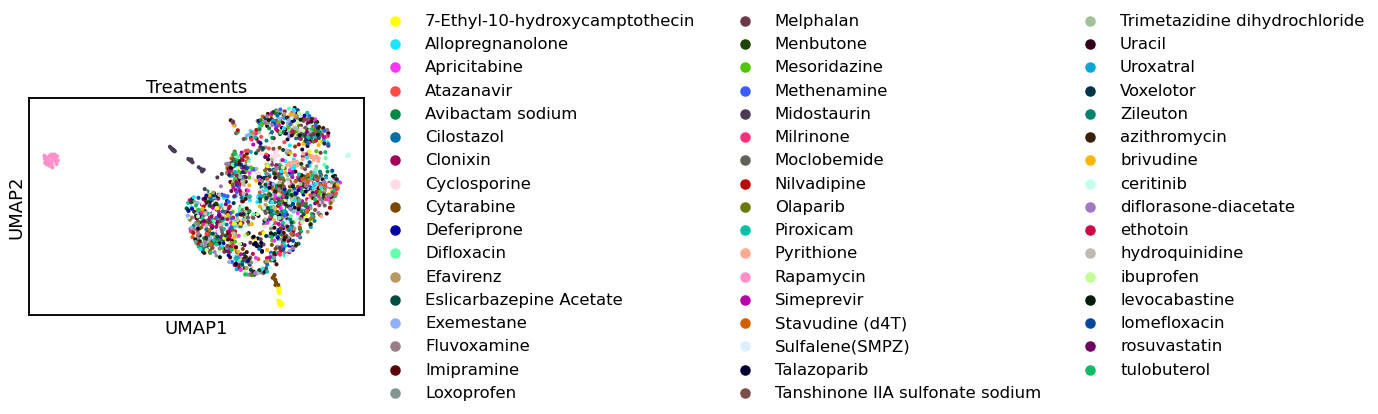

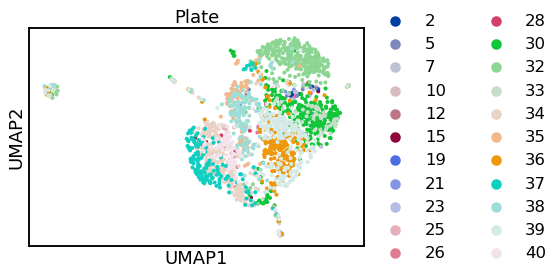

In [4]:
# Select 50 most frequent treatments
treatments = adata.obs["treatment"].value_counts().nlargest(50).index
adata = adata[adata.obs["treatment"].isin(treatments)].copy()

sc.pp.neighbors(adata, n_neighbors=15, use_rep = "X")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["treatment"], title = "Treatments")
sc.pl.umap(adata, color="plate", title = "Plate")

Since there are too many treatments to investigate them all, we subset for the top 50 most frequent treatments. 

We see clustering of some treatments but the clustering by plate is stronger. However, we also see and expect some overlay or intermixing of the clusters because all these treatments are experimental with the goal of trying to counteract the storm-svere level of cytokine activitiy as found in severe COVID-19 patients. Thus, not all treatments may be equally effective.

Thus, our batch key is "plate" and the label key (the biology we want to preserve) is "treatment".

### B. Find which metrics are applicable for this dataset<a class="anchor" id="before_sub2"></a>


The computed metrics for removal of batch effects are:

- Graph connectivity score 
- iLISI
- (kBET)
- PCR
- Silhouette batch 

Regarding kBET, it was not run as it kept killing the kernal session.
Regarding the PCR: this score is computed after integration once with the comparison (scib.metrics.pcr_comparison()) and once without the comparison (scib.metrics.pcr()).

The following biological conservation metrics are calculated:

- cLISI
- Silhouette biological
- NMI 
- ARI
- Isolated Label score F1
- Isolated Label score ASW

The isolated label score is also considered for this dataset, because in each batch, i.e. plate, we do not always have all labels. Specifically, only plate 53 has all three disease_conditions "blank", "healthy" and "storm-severe". Thus the label "blank" is only present in one batch, i.e. one plate.


Metrics excluded for this dataset are:

- Cell Cycle Conservation score
- HVG Overlap 
- Trajectory Conservation

We exclude the CCC, HVG Overlap and Trajectory Conservation score for this dataset, because we have image embeddings.

### C. Compute scIB metrics <a class="anchor" id="before_sub3"></a>

#### i. Batch correction metrics <a class="anchor" id="scIB_sub1"></a>

In [5]:
#Graph connectivity score
sc.pp.neighbors(adata, n_neighbors=15, use_rep = "X")
gc = scib.me.graph_connectivity(adata, label_key="treatment")

In [6]:
#iLISI
ilisi = scib.me.ilisi_graph(adata, batch_key="plate", type_="knn")

Chunk 89 does not have enough neighbors. Skipping...
Chunk 179 does not have enough neighbors. Skipping...
Chunk 181 does not have enough neighbors. Skipping...
Chunk 185 does not have enough neighbors. Skipping...
Chunk 348 does not have enough neighbors. Skipping...
Chunk 385 does not have enough neighbors. Skipping...
Chunk 404 does not have enough neighbors. Skipping...
Chunk 410 does not have enough neighbors. Skipping...
Chunk 598 does not have enough neighbors. Skipping...
Chunk 615 does not have enough neighbors. Skipping...
Chunk 621 does not have enough neighbors. Skipping...
Chunk 707 does not have enough neighbors. Skipping...
Chunk 752 does not have enough neighbors. Skipping...
Chunk 781 does not have enough neighbors. Skipping...
Chunk 787 does not have enough neighbors. Skipping...
Chunk 838 does not have enough neighbors. Skipping...
Chunk 874 does not have enough neighbors. Skipping...
Chunk 1050 does not have enough neighbors. Skipping...
Chunk 1093 does not have eno

In [7]:
#kbet
#kbet = scib.me.kBET(adata, batch_key="plate", label_key=treatment_labels, type_="knn")

In [8]:
#principal component regression, computes PCA if not provided: 
pcr_nc = scib.me.pcr(adata, covariate="plate")

In [9]:
#silhouette batch 
#only takes a slot in .obsm as input, i.e. embedding or pca -> compute PCA 
sc.pp.pca(adata, n_comps = 100)
silhouette_batch = scib.me.silhouette_batch(adata, batch_key="plate", label_key="treatment", embed="X_pca")

mean silhouette per group:                                  silhouette_score
group                                            
7-Ethyl-10-hydroxycamptothecin           0.903794
Allopregnanolone                         0.898476
Apricitabine                             0.884856
Atazanavir                               0.879607
Avibactam sodium                         0.924780
Cilostazol                               0.918950
Clonixin                                 0.897020
Cyclosporine                             0.876156
Cytarabine                               0.831804
Deferiprone                              0.904751
Difloxacin                               0.912687
Efavirenz                                0.884278
Eslicarbazepine Acetate                  0.891938
Exemestane                               0.910431
Fluvoxamine                              0.867357
Imipramine                               0.866912
Loxoprofen                               0.821054
Melphalan              

#### ii. Biological conservation metrics <a class="anchor" id="scIB_sub2"></a>

In [10]:
#cell type lisi -> specify it as "knn"
clisi = scib.me.clisi_graph(adata, label_key="treatment", type_="knn")

Chunk 89 does not have enough neighbors. Skipping...
Chunk 179 does not have enough neighbors. Skipping...
Chunk 181 does not have enough neighbors. Skipping...
Chunk 185 does not have enough neighbors. Skipping...
Chunk 348 does not have enough neighbors. Skipping...
Chunk 385 does not have enough neighbors. Skipping...
Chunk 404 does not have enough neighbors. Skipping...
Chunk 410 does not have enough neighbors. Skipping...
Chunk 598 does not have enough neighbors. Skipping...
Chunk 615 does not have enough neighbors. Skipping...
Chunk 621 does not have enough neighbors. Skipping...
Chunk 707 does not have enough neighbors. Skipping...
Chunk 752 does not have enough neighbors. Skipping...
Chunk 781 does not have enough neighbors. Skipping...
Chunk 787 does not have enough neighbors. Skipping...
Chunk 838 does not have enough neighbors. Skipping...
Chunk 874 does not have enough neighbors. Skipping...
Chunk 1050 does not have enough neighbors. Skipping...
Chunk 1093 does not have eno

In [11]:
#silhouette biological
silhouette = scib.me.silhouette(adata, label_key="treatment", embed="X_pca")

In [12]:
#NMI
# cluster_optimal_resolution uses precomputed knn if use_rep == None
nmi = scib.metrics.cluster_optimal_resolution(adata, label_key = "treatment",cluster_key = "cluster", metric = scib.me.nmi, return_all = True)[1]

resolution: 0.1, nmi: 0.09545976029936457
resolution: 0.2, nmi: 0.09973821824698395
resolution: 0.3, nmi: 0.1065948582505572
resolution: 0.4, nmi: 0.1256338460977594
resolution: 0.5, nmi: 0.12324694733839331
resolution: 0.6, nmi: 0.13206838043683863
resolution: 0.7, nmi: 0.1341510657391389
resolution: 0.8, nmi: 0.13995282934867154
resolution: 0.9, nmi: 0.14683544913234958
resolution: 1.0, nmi: 0.14336601284689082
resolution: 1.1, nmi: 0.15572829931985746
resolution: 1.2, nmi: 0.15432444164215386
resolution: 1.3, nmi: 0.16256393346006212
resolution: 1.4, nmi: 0.16202147587895666
resolution: 1.5, nmi: 0.1662019884666536
resolution: 1.6, nmi: 0.17003418604319193
resolution: 1.7, nmi: 0.17039848089424098
resolution: 1.8, nmi: 0.17276202822404832
resolution: 1.9, nmi: 0.18309133609109907
resolution: 2.0, nmi: 0.18317013804335142
optimised clustering against treatment
optimal cluster resolution: 2.0
optimal score: 0.18317013804335142


In [13]:
#ARI
# cluster_optimal_resolution uses precomputed knn if use_rep == None
ari = scib.metrics.cluster_optimal_resolution(adata, label_key = "treatment",cluster_key = "cluster", metric = scib.me.ari, return_all = True)[1]

resolution: 0.1, ari: 0.002632584583180162
resolution: 0.2, ari: 0.00587275105783089
resolution: 0.3, ari: 0.0067157324068626055
resolution: 0.4, ari: 0.009275113831835623
resolution: 0.5, ari: 0.012609457864979344
resolution: 0.6, ari: 0.012663466334072022
resolution: 0.7, ari: 0.013048428886319944
resolution: 0.8, ari: 0.014885736325139214
resolution: 0.9, ari: 0.0157001633645744
resolution: 1.0, ari: 0.015490112265357849
resolution: 1.1, ari: 0.02002228071789682
resolution: 1.2, ari: 0.021037496854474556
resolution: 1.3, ari: 0.02286990885383671
resolution: 1.4, ari: 0.02332113583961737
resolution: 1.5, ari: 0.02331607082667004
resolution: 1.6, ari: 0.024910080488172184
resolution: 1.7, ari: 0.024041311129648614
resolution: 1.8, ari: 0.024841616592707776
resolution: 1.9, ari: 0.026922789739507253
resolution: 2.0, ari: 0.025196025526271083
optimised clustering against treatment
optimal cluster resolution: 1.9
optimal score: 0.026922789739507253


In [14]:
#Isolated label score F1
isolated_label_F1 = scib.me.isolated_labels_f1(adata, batch_key="plate", label_key="treatment", embed = "X_pca")

isolated labels: no more than 6 batches per label
Compute neighbors on rep X_pca
7-Ethyl-10-hydroxycamptothecin: 0.5538461538461539
Compute neighbors on rep X_pca
Apricitabine: 0.10204081632653061
Compute neighbors on rep X_pca
Atazanavir: 0.125
Compute neighbors on rep X_pca
Avibactam sodium: 0.08856088560885607
Compute neighbors on rep X_pca
Cilostazol: 0.11267605633802817
Compute neighbors on rep X_pca
Clonixin: 0.15
Compute neighbors on rep X_pca
Cyclosporine: 0.2857142857142857
Compute neighbors on rep X_pca
Cytarabine: 0.3384615384615385
Compute neighbors on rep X_pca
Deferiprone: 0.08219178082191782
Compute neighbors on rep X_pca
Difloxacin: 0.08450704225352113
Compute neighbors on rep X_pca
Efavirenz: 0.06535947712418301
Compute neighbors on rep X_pca
Eslicarbazepine Acetate: 0.08450704225352113
Compute neighbors on rep X_pca
Exemestane: 0.078125
Compute neighbors on rep X_pca
Fluvoxamine: 0.08421052631578949
Compute neighbors on rep X_pca
Imipramine: 0.099009900990099
Compute 

In [15]:
#Isolated label score ASW
isolated_label_ASW = scib.me.isolated_labels_asw(adata, batch_key="plate", label_key="treatment", embed="X_pca")

isolated labels: no more than 6 batches per label
7-Ethyl-10-hydroxycamptothecin: 0.4125955179333687
Apricitabine: 0.4727020934224129
Atazanavir: 0.44375456124544144
Avibactam sodium: 0.4835966154932976
Cilostazol: 0.4706479236483574
Clonixin: 0.4807825796306133
Cyclosporine: 0.4298207089304924
Cytarabine: 0.413736954331398
Deferiprone: 0.46081631630659103
Difloxacin: 0.4654487855732441
Efavirenz: 0.4514993578195572
Eslicarbazepine Acetate: 0.4682326912879944
Exemestane: 0.46692948043346405
Fluvoxamine: 0.47670794650912285
Imipramine: 0.44540534541010857
Loxoprofen: 0.46279530227184296
Melphalan: 0.42224638164043427
Menbutone: 0.463410634547472
Mesoridazine: 0.4867456117644906
Methenamine: 0.43620825558900833
Midostaurin: 0.46883933804929256
Milrinone: 0.46893733739852905
Moclobemide: 0.46435951068997383
Nilvadipine: 0.43254830688238144
Olaparib: 0.47114061564207077
Piroxicam: 0.46271077543497086
Pyrithione: 0.4731005132198334
Rapamycin: 0.7196025401353836
Simeprevir: 0.472481869161129

#### iii. Have a look at result <a class="anchor" id="scIB_sub3"></a>
Unintegrated results

1. Batch correction metrics

In [45]:
unintegrated_metrics = pd.DataFrame({"Unintegrated: Batch correction metrics": []})

unintegrated_metrics.loc["Graph_Conn"] = gc
unintegrated_metrics.loc["iLISI"] = ilisi
unintegrated_metrics.loc["PCR_NC"] = pcr_nc
unintegrated_metrics.loc["PCR_Comparison"] = None
#unintegrated_metrics.loc["kBET"] = kbet
unintegrated_metrics.loc["Silhouette_batch"] = silhouette_batch

unintegrated_metrics

,Unintegrated: Batch correction metrics
Graph_Conn,0.227222
iLISI,0.078027
PCR_NC,0.156220
PCR_Comparison,NaN
Silhouette_batch,0.889508


Graph connectivity score:
- Score range: ranges from 0 to 1.
- Meaning: measures the connectedness of cells within each batch after applying batch correction. A higher score closer to 1 indicates that the batch correction has successfully increased the connectivity and reduced the isolation of cells within each batch. It implies that cells within the same biological group or condition are more interconnected and grouped together, while cells from different batches are more separated.

iLISI:
- Score range: ranges from 0 to 1.
- Meaning: quantifies the consistency of local neighborhood relationships within and between batches. A higher iLISI score closer to 1 suggests better batch correction performance. It indicates that cells within the same batch have more consistent neighborhood relationships, resembling cells from the same biological condition, while cells from different batches have distinct neighborhood relationships.

kBET:
- Score range: ranges from 0 to 1.
- Meaning: assesses the batch effects in single-cell RNA-seq data. A score closer to 0 indicates strong batch effects, meaning that the variation between batches dominates the biological variation. A score closer to 1 indicates minimal batch effects, suggesting that the biological variation is the primary driver of the observed differences.

PCR:
- Score range: ranges from negative to positive values.
- Meaning: utilizes principal component analysis (PCA) to reduce the dimensionality of the data and perform regression analysis for batch correction. The score represents the performance of the regression model, where higher positive scores indicate better prediction accuracy and successful batch correction. Conversely, lower negative scores indicate poorer prediction accuracy and less effective batch correction.

Silhouette batch:
- Score range: ranges from -1 to 1.
- Meaning: measures the quality of batch correction by assessing the separation between cells from different batches. A higher silhouette batch score closer to 1 indicates better batch correction. It implies that cells within the same biological condition are well-separated from cells of other conditions, suggesting successful removal or reduction of batch effects. Conversely, a score closer to -1 indicates poor batch correction, where cells from different batches are not well-separated.

2. Biological conservation metrics

In [46]:
unintegrated_metrics_1 = pd.DataFrame({"Unintegrated: biol. conservation metrics": []})

unintegrated_metrics_1.loc["cLISI"] = clisi
unintegrated_metrics_1.loc["Silhouette"] = silhouette
unintegrated_metrics_1.loc["NMI"] = nmi
unintegrated_metrics_1.loc["ARI"] = ari
unintegrated_metrics_1.loc["Isolated_label_F1"] = isolated_label_F1
unintegrated_metrics_1.loc["Isolated_label_ASW"] = isolated_label_ASW

unintegrated_metrics_1

,Unintegrated: biol. conservation metrics
cLISI,0.794497
Silhouette,0.466110
NMI,0.183170
ARI,0.026923
Isolated_label_F1,0.158131
Isolated_label_ASW,0.466494


cLISI:
- Score range: ranges from 0 to 1.
- Meaning: quantifies the consistency of local neighborhood relationships of cell types within and between batches. A higher cLISI score closer to 1 suggests better batch correction performance. It indicates that the neighborhood relationships of cell types are more consistent within the same batch, resembling the biological structure, while being distinct from cell types in different batches.

Silhouette Biological:
- Score range: ranges from -1 to 1.
- Meaning: measures the quality of batch correction by evaluating the separation between different cell types or biological conditions. A higher silhouette biological score closer to 1 indicates better batch correction. It suggests that cells from the same biological condition are well-separated from cells of other conditions, indicating successful removal or reduction of batch effects. Conversely, a score closer to -1 indicates poor batch correction, where cell types or biological conditions are not well-separated.

NMI:
- Score range: ranges from 0 to 1.
- Meaning: quantifies the similarity between the clustering results of different batches or conditions. A higher NMI score closer to 1 suggests better batch correction. It indicates a high degree of similarity between the cluster assignments of cells within the same biological condition, reflecting successful batch effect removal. A score of 0 indicates no mutual information or similarity between the clusters.

ARI:
- Score range: ranges from -1 to 1.
- Meaning: measures the similarity between the cluster assignments of different batches or conditions, adjusted for chance. A higher ARI score closer to 1 indicates better batch correction. It suggests a high degree of similarity between the cluster assignments of cells within the same biological condition, reflecting successful batch effect removal. A score of 0 indicates the expected similarity by chance, while negative scores indicate dissimilarity.

Isolated Label Score F1:
- Score range: ranges from 0 to 1.
- Meaning: measures the preservation of cell type labels after batch correction. A higher F1 score closer to 1 indicates better preservation of cell type information. It suggests that the batch correction method has successfully maintained the cell type identities and avoided label changes across different batches.

Isolated Label Score ASW:
- Score range: ranges from -1 to 1.
- Meaning: measures the separation and compactness of cell type clusters after batch correction. A higher ASW score closer to 1 indicates better separation and compactness of cell type clusters. It suggests that cells of the same type form tight and well-separated clusters, indicating successful preservation of cell type information.

In [16]:
adata.write_h5ad(
    "rxrx19b_top_50_treatments.h5ad",
    compression="gzip"
)

## II. Integration  <a class="anchor" id="integrate"></a>

### A. Harmony <a class="anchor" id="integrate_sub1"></a>

In [17]:
harmony = adata.copy()
scib.integration.harmony(harmony, batch = "plate")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


AnnData object with n_obs × n_vars = 1836 × 128
    obs: 'well_id', 'cell_type', 'experiment', 'plate', 'well', 'site', 'disease_condition', 'treatment', 'treatment_conc', 'SMILES', 'cluster', 'silhouette_temp'
    uns: 'neighbors', 'umap', 'treatment_colors', 'plate_colors', 'pca', 'leiden'
    obsm: 'X_umap', 'X_pca', 'X_emb'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## III. After integration  <a class="anchor" id="after"></a>

### A. Harmony: Compute scIB metrics <a class="anchor" id="after_sub1"></a>

In [18]:
# the following function expects an embedding output; X_emb
# can of course be adjusted so that it takes all integration outputs as input 
def compute_metrics_after(adata_pre, adata_post, label_key, batch_key, integration_method):
    results = scib.metrics.metrics(adata_pre, adata_post, batch_key, label_key, embed='X_emb', cluster_key='cluster',
                     ari_=True, nmi_=True,silhouette_=True, pcr_=True, graph_conn_=True, kBET_=False, lisi_graph_=True, 
                                   isolated_labels_ = True, isolated_labels_f1_ = True,  type_="emb")
    
    # compute only the principal component regression score without the comparison: 
    pcr = scib.me.pcr(adata_post, covariate=batch_key, embed="X_emb")
    #append pcr to results: 
    results.loc["PCR_NC"] = pcr
    # remove rows containing NaNs for metrics that weren't computed
    results = results.drop(["cell_cycle_conservation", "hvg_overlap", "trajectory"])
    #change row names: 
    results = results.rename({"graph_conn": "Graph_Conn", "PCR_batch": "PCR_Comparison", "ASW_label/batch": "Silhouette_batch",
                             "ASW_label": "Silhouette", "NMI_cluster/label": "NMI", "ARI_cluster/label": "ARI"}, axis='index')
    #change column name 
    results = results.rename(columns={0: integration_method})
    
    return results

In [19]:
harmony_metrics = compute_metrics_after(adata, harmony, "treatment", "plate", "Harmony") 

/home/mahim/.local/lib/python3.10/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...
Isolated labels F1...
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_emb
Compute neighbors on rep X_e

In [50]:
#harmony_metrics

# Create a list of row names to split on
split_rows = ["Graph_Conn", "iLISI", "PCR_NC", "PCR_Comparison", "Silhouette_batch"]

# Filter the DataFrame based on the split rows
harmony_batch_correction = harmony_metrics.loc[split_rows].copy()
harmony_biological_conservation = harmony_metrics.drop(split_rows).copy()

# Drop the "kBET" row from harmony_biological_conservation
harmony_biological_conservation.drop("kBET", inplace=True)

# Rename the column in harmony_batch_correction
harmony_batch_correction = harmony_batch_correction.rename(columns={"Harmony": "Harmony: Batch_correction metrics"})

# Rename the column in harmony_other
harmony_biological_conservation = harmony_biological_conservation.rename(columns={"Harmony": "Harmony: biol. conservation metrics"})

In [51]:
# Print the resulting DataFrames
harmony_batch_correction

,Harmony: Batch_correction metrics
Graph_Conn,0.227222
iLISI,0.078573
PCR_NC,0.033015
PCR_Comparison,0.788664
Silhouette_batch,0.882341


In [52]:
harmony_biological_conservation

,Harmony: biol. conservation metrics
NMI,0.168141
ARI,0.027764
Silhouette,0.464476
isolated_label_F1,0.158302
isolated_label_silhouette,0.464572
cLISI,0.795914


### B. Harmony: Before and after UMAP visualization <a class="anchor" id="after_sub2"></a>

<b> Unintegrated: <b>

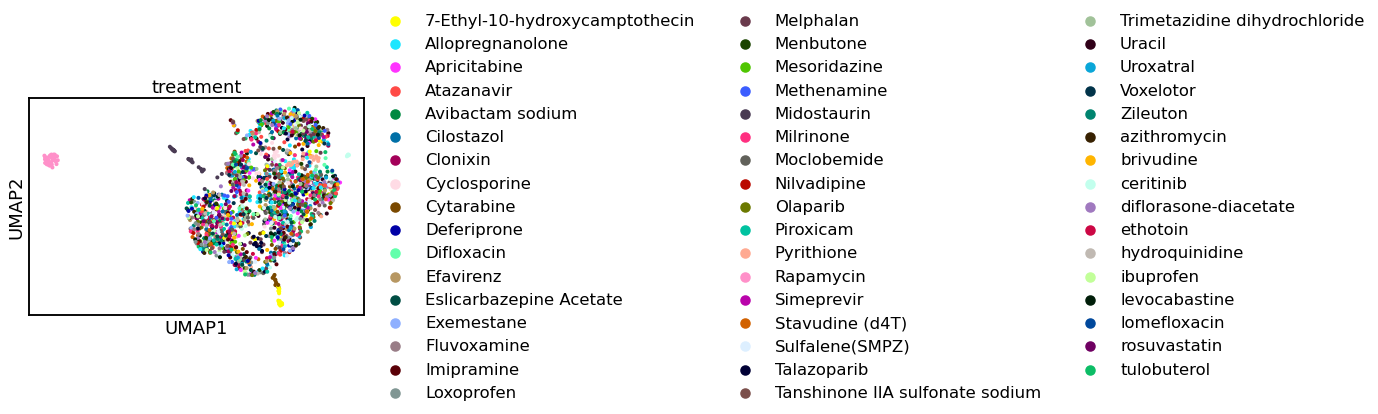

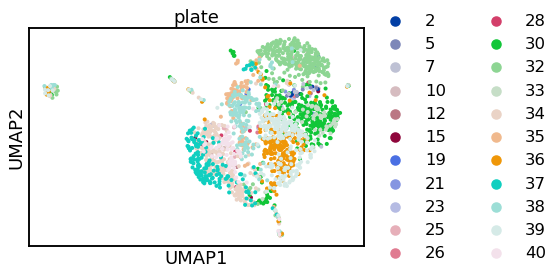

In [53]:
sc.pl.umap(adata, color="treatment")
sc.pl.umap(adata, color="plate")

<b> After harmony integration: <b>

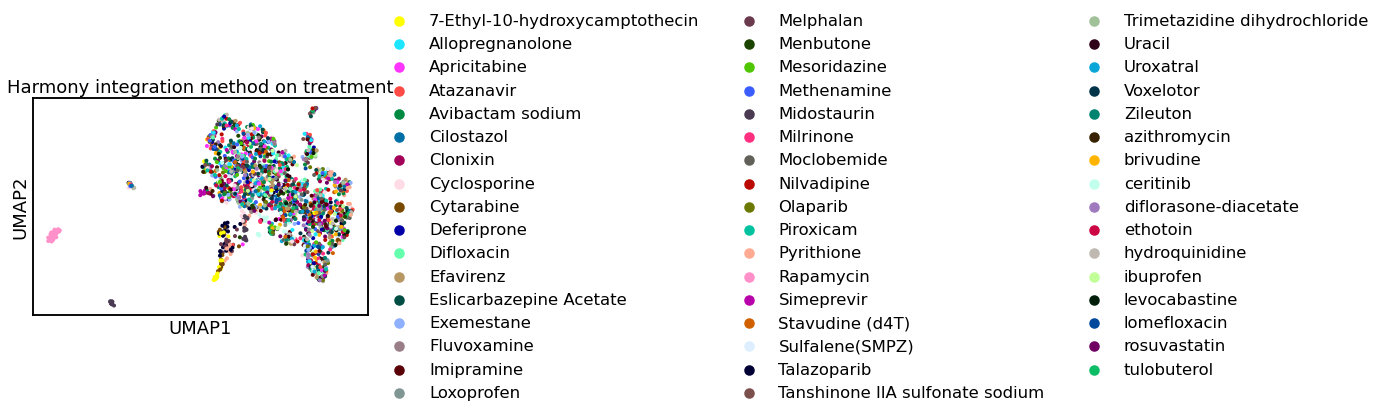

In [54]:
sc.pp.neighbors(harmony, n_neighbors=15, use_rep = "X_emb")
sc.tl.umap(harmony)
sc.pl.umap(harmony, color= "treatment", title = "Harmony integration method on treatment")

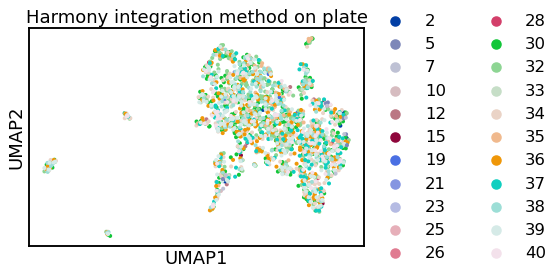

In [55]:
sc.pp.neighbors(harmony, n_neighbors=15, use_rep = "X_emb")
sc.tl.umap(harmony)
sc.pl.umap(harmony, color= "plate", title = "Harmony integration method on plate")

We clearly see that the plate effect is drastically reduced after integration with harmony. 

In [20]:
harmony.write_h5ad(
    "rxrx19b_top_50_treatments_harmony.h5ad",
    compression="gzip"
)